# Probabilistic Test of `bngmetric`
One of the many reasons I wanted to develop the Python implementation of the BNG  metric with JAX is so that I could begin to encorporate a probabilistic component to the metric. In this notebook, I will test that what I have developed for the baseline does indeed work with `numpyro` by demonstrating it to propogate uncertianties through the metric

In [62]:
import jax
import jax.numpy as jnp
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import seed, trace, condition, plate
import matplotlib.pyplot as plt
import seaborn as sns # For nicer plots

# Import your JAX BNG calculation functions and constants
# Assuming your bngmetric package is installed or its path is set up
from bngmetric.core_calculations import calculate_total_bng_from_jax_arrays, calculate_batched_baseline_bng_units,calculate_baseline_bng_unit
from bngmetric.constants import (
    HABITAT_TYPE_TO_ID, CONDITION_CATEGORY_TO_ID,
    ID_TO_DISTINCTIVENESS_VALUE, CONDITION_MULTIPLIERS_MATRIX,
    # You might also want to import the reverse mapping for human-readable output
    # e.g., ID_TO_HABITAT_TYPE = {v: k for k, v in HABITAT_TYPE_TO_ID.items()}
)

# Configure JAX for CPU for consistent behavior if not on GPU
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True) # Enable 64-bit precision for better numerical stability

## Uncertianty in classification.
Classifications are by their nature subjective, and therefore different surveyors could concievably give different labels to the same landcover.

Are bigger level of uncertianty is introduced with the use of ML trained landcover maps, however many of them also provide confusion matrices which we could use as a basis for capturing that uncertianty.

For this example, I will construct a toy confusion matrix for all habitat types in the metric, assuming the following:
* 0 probability for habitats with different broad types
* a constant uncertianty for all habitats within the same broad category

This is a toy model, in reality I could use the confusion matrix provided by any decent ML derived landcover map.
For human surveyed data, I could call on some domain knowledge from ecologists to determine the appropriate probabilites between broad categories

In [46]:
import jax
import jax.numpy as jnp
from bngmetric.constants import LEVEL2_IDS_ARRAY
num_habitats = 135
dirichlet_concentration_same_class = 5.0  # Concentration within the same class
dirichlet_concentration_diff_class = 0.0  # Concentration for different classes

# Assuming you have a way to group habitats into broad classes
# For example, a JAX array for class ID, ordered by habitat ID

# habitat_class_mapping = jnp.array([0,0,0,3,4,2,2,2,2])  # Example
# For simplicity, let's assume the first N habitats belong to one class,
# the next M to another, and so on.  You'll need to adapt this to your
# actual habitat classification system.

# Example: Assume 3 broad classes
num_classes = jnp.max(LEVEL2_IDS_ARRAY)
habitats_per_class = num_habitats // num_classes  # Roughly equal distribution



# Generate a random matrix
rng = jax.random.PRNGKey(42)
#random_matrix = jax.random.uniform(rng, (num_habitats, num_habitats))
random_matrix=jnp.zeros((num_habitats, num_habitats))  # For testing, use a zero matrix
symmetric_matrix = (random_matrix + random_matrix.T) / 2

# Sharpen the diagonal and also entries within the same broad class
for i in range(num_habitats):
    for j in range(num_habitats):
        if LEVEL2_IDS_ARRAY[i] == LEVEL2_IDS_ARRAY[j]:
            symmetric_matrix = symmetric_matrix.at[i, j].add(dirichlet_concentration_same_class)
        else:
            symmetric_matrix = symmetric_matrix.at[i, j].add(dirichlet_concentration_diff_class)

# Further sharpen the diagonal
symmetric_matrix = symmetric_matrix + jnp.eye(num_habitats) * dirichlet_concentration_same_class


# Normalize each row to sum to 1
CONFUSION_MATRIX = symmetric_matrix / symmetric_matrix.sum(axis=1, keepdims=True)

Text(50.722222222222214, 0.5, 'True Habitat Type')

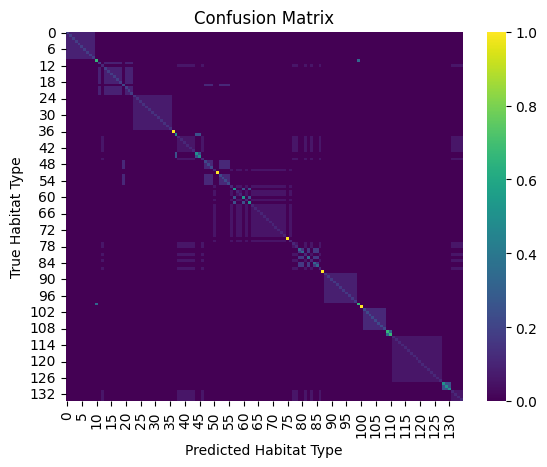

In [121]:
sns.heatmap(CONFUSION_MATRIX, cmap='viridis')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Habitat Type")
plt.ylabel("True Habitat Type")

## Generate a toy example
Now lets create an example input from the metric, i.e. some habitats, conditions, area and strategic significance

In [ ]:

# --- Example Input Data (similar to your DataFrame) ---
# Ensure these habitat names exist in your HABITAT_TYPE_TO_ID mapping
example_df = pd.DataFrame({
    'Habitat': ['Grassland - Lowland calcareous grassland', 'Grassland - Modified grassland', 'Woodland and forest - Lowland mixed deciduous woodland'],
    'Condition': ['Good', 'Moderate', 'Good'],
    'Area': [5.0, 20.0, 8.0],
    'Strategic_Significance': [1.0, 1.0, 1.15]
})


# Get reverse mapping for clear output
ID_TO_HABITAT_TYPE = {v: k for k, v in HABITAT_TYPE_TO_ID.items()}

# Convert DataFrame columns to JAX arrays using your constants mapping
classified_habitat_ids_input = jnp.array([
    HABITAT_TYPE_TO_ID[ht] for ht in example_df['Habitat'].values
])
print("Classified Habitat IDs (IDs):", classified_habitat_ids_input)
condition_ids_input = jnp.array([
    CONDITION_CATEGORY_TO_ID[c] for c in example_df['Condition'].values
])
areas_input = jnp.array(example_df['Area'].values, dtype=jnp.float64) # Use float64 for better precision
strategic_multipliers_input = jnp.array(example_df['Strategic_Significance'].values, dtype=jnp.float64)

# Print initial classification for reference
print("Initial Classified Habitats (IDs):", classified_habitat_ids_input)
print("Initial Areas:", areas_input)

Classified Habitat IDs (IDs): [13 16 89]
Initial Classified Habitats (IDs): [13 16 89]
Initial Areas: [ 5. 20.  8.]


## Probabilistic Sampling
Here we use `numpyro` to construct a probabilistic model. I have chosen `numpyro` as I am familiar with it, it utilizes `JAX` and its probabilistic programming approach naturally fits how I am approaching this problem.

The model will:
1. Sample from a confusion matrix to model uncertainty in habitat classification
2. Sample area measurements with uncertainty using truncated normal distributions
3. Ensure consistency between habitat types and condition categories (selecting maximum condition where the input condition is no longer allowed by habitat)
4. Calculate BNG units with these uncertain inputs to propagate uncertainty through the metric

This allows us to quantify uncertainty in the final biodiversity net gain calculations

In [144]:
from jax import grad
from jax import vmap

samples = []
bng_units = []
areas= []
conditions=[]
def condition_checker_cond(s, c0):
    c = get_condition_multiplier(s, c0)

    # Use jax.lax.cond for conditional logic
    return jax.lax.cond(c < 1.0,  # Predicate
                        lambda _: jnp.argmax(CONDITION_MULTIPLIERS_MATRIX[s]), # True function
                        lambda _: c0, # False function
                        None) # Operand (not strictly needed here, but required by API)


for _ in range(1000):
      with handlers.seed(rng_seed=_):
            num_parcels = classified_habitat_ids_input.shape[0]
            with plate("parcels", num_parcels):
                  classification_probabilities = CONFUSION_MATRIX[classified_habitat_ids_input]
                  sample = numpyro.sample(
                        "true_habitat_id", 
                        dist.Categorical(probs=classification_probabilities)
                  )
                  samples.append(sample)
                  area_means = areas_input # We use the input 'areas' as the mean for sampling
                  area_stds = jnp.array([0.5, 1.0, 0.8], dtype=jnp.float64) # Illustrative std for each parcel
        
                  area_sampled = numpyro.sample(
                        "area_sampled", 
                        dist.TruncatedNormal(area_means, area_stds,low=0.0)
                  )
                  
                  # Check that the sampled habitats and conditions are consistent
                  condition=vmap(condition_checker_cond)(sample, condition_ids_input)  # Check condition consistency
                  conditions.append(condition)  # Store the condition for each sample
                  # 3. Calculate BNG Units using the JAX metric with sampled 'true' habitats and areas
                  #    Pass the sampled 'true_habitat_ids_sampled' to your JAX function
                  bng_units_per_parcel = calculate_batched_baseline_bng_units(
                        sample,    # The sampled true habitat IDs
                        condition.astype(jnp.int32),               # Fixed for now, could also be sampled
                        area_sampled,                # The sampled area
                        strategic_multipliers_input        # Fixed for now, could also be sampled
                  )
                  areas.append(area_sampled)  # Append the sampled areas for consistency
                  bng_units.append(bng_units_per_parcel)
samples = jnp.stack(samples)
bng_units = jnp.stack(bng_units)
areas = jnp.stack(areas)


Text(0.5, 1.0, 'Distribution of BNG Units from Probabilistic Sampling')

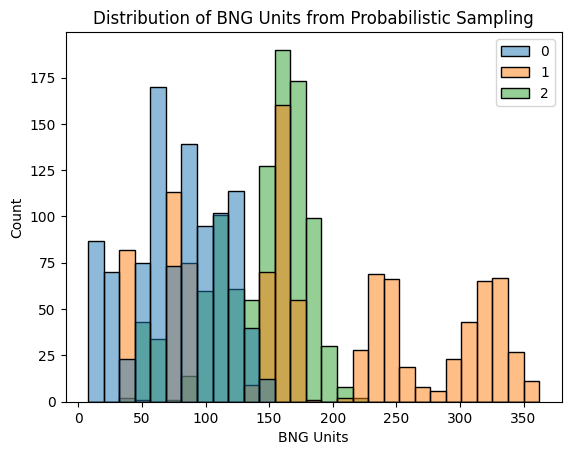

In [148]:
sns.histplot(bng_units)
plt.xlabel("BNG Units")
plt.title("Distribution of BNG Units from Probabilistic Sampling")

and now the same for total bng units across whole site

Text(0.5, 1.0, 'Distribution of Total BNG Units from Probabilistic Sampling')

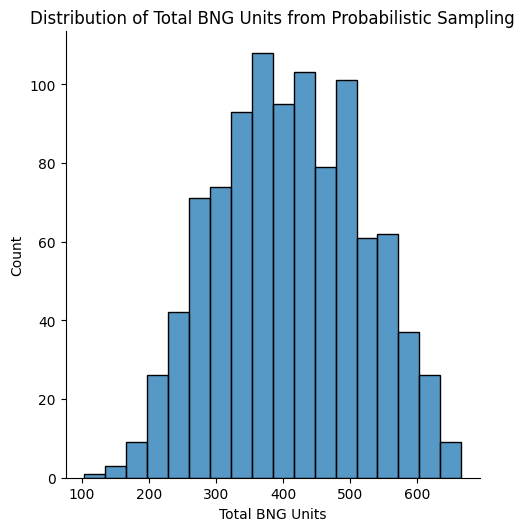

In [150]:
sns.displot(bng_units.sum(axis=1))  # Sum across parcels to get total BNG units per sample
plt.xlabel("Total BNG Units")
plt.title("Distribution of Total BNG Units from Probabilistic Sampling")

Why is this cool? It allows us to ask probability qeustions such as:

In [ ]:
print("What is the probability that the total BNG units across the site is greater than 300?")
total_bng_units=bng_units.sum(axis=1)
numerator=(total_bng_units>300)
print("Pr(total BNG units < 100):", numerator.sum()/total_bng_units.shape[0])



What is the probability that the total BNG units across the site is greater than 300?
Pr(total BNG units < 100): 0.834


For baselinining the need for this isnt so obvious, but for the creation and enhancement, it could be, especially if we introduce other source of uncertianty, e.g. the probability of failure based on climate predictions (e.g. wildfire), missmanagement, disease (think ash dieback) etc


Also, this type of probabilsitic approach, will enable very useful feedback such as what habitat should a manual survey focus on etc. Partner this with an LLM agent and it could provide a powerful chatbot tool